In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
import tensorflow as tf

In [30]:
df = pd.read_csv("data.csv")
df = df.rename(columns={"tension_strenght": "tensile_strength"})
df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,grid,220,60,40,abs,0,25,18,1.2
1,0.02,7,90,honeycomb,225,65,40,abs,25,32,16,1.4
2,0.02,1,80,grid,230,70,40,abs,50,40,8,0.8
3,0.02,4,70,honeycomb,240,75,40,abs,75,68,10,0.5
4,0.02,6,90,grid,250,80,40,abs,100,92,5,0.7


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   layer_height        50 non-null     float64
 1   wall_thickness      50 non-null     int64  
 2   infill_density      50 non-null     int64  
 3   infill_pattern      50 non-null     object 
 4   nozzle_temperature  50 non-null     int64  
 5   bed_temperature     50 non-null     int64  
 6   print_speed         50 non-null     int64  
 7   material            50 non-null     object 
 8   fan_speed           50 non-null     int64  
 9   roughness           50 non-null     int64  
 10  tensile_strength    50 non-null     int64  
 11  elongation          50 non-null     float64
dtypes: float64(2), int64(8), object(2)
memory usage: 4.8+ KB


In [32]:
for column in df.columns:
    print(str(column)+": "+str(df[column].unique()))
    print()

layer_height: [0.02 0.06 0.1  0.15 0.2 ]

wall_thickness: [ 8  7  1  4  6 10  5  9  2  3]

infill_density: [90 80 70 40 10 20 50 30 60]

infill_pattern: ['grid' 'honeycomb']

nozzle_temperature: [220 225 230 240 250 200 205 210 215]

bed_temperature: [60 65 70 75 80]

print_speed: [ 40  60 120]

material: ['abs' 'pla']

fan_speed: [  0  25  50  75 100]

roughness: [ 25  32  40  68  92  60  55  21  24  30  75 118 200 220 126 145  88  74
 120 144 265 312 368 180 176 128 138 121 168 154 225 289 326 192 212 172
 163 276 298 360 357 321 278 244]

tensile_strength: [18 16  8 10  5 24 12 14 27 25 37  9 23 26 33 29 19 11 34 13 22  4 35 28
 21 30]

elongation: [1.2 1.4 0.8 0.5 0.7 1.1 1.3 1.5 1.7 2.4 1.  2.2 1.9 1.6 2.1 2.  0.9 0.4
 1.8 2.9 0.6 2.8 2.3 3.3 3.1 2.7 3.2]



In [33]:
#In this data set, ABS and PLA assigned 0 and 1 values for materials (abs = 0, pla = 1)
df.material = [0 if each=='abs' else 1 for each in df.material]

#In this data set, grid and honeycomb assigned 0 and 1 values for infill_pattern (grid = 0, honeycomb = 1)
df.infill_pattern = [0 if each=='grid' else 1 for each in df.infill_pattern]

df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,0.02,8,90,0,220,60,40,0,0,25,18,1.2
1,0.02,7,90,1,225,65,40,0,25,32,16,1.4
2,0.02,1,80,0,230,70,40,0,50,40,8,0.8
3,0.02,4,70,1,240,75,40,0,75,68,10,0.5
4,0.02,6,90,0,250,80,40,0,100,92,5,0.7


In [34]:
df.layer_height = df.layer_height*100
df.elongation = df.elongation*100

In [35]:
df.head()

,layer_height,wall_thickness,infill_density,infill_pattern,nozzle_temperature,bed_temperature,print_speed,material,fan_speed,roughness,tensile_strength,elongation
0,2.0,8,90,0,220,60,40,0,0,25,18,120.0
1,2.0,7,90,1,225,65,40,0,25,32,16,140.0
2,2.0,1,80,0,230,70,40,0,50,40,8,80.0
3,2.0,4,70,1,240,75,40,0,75,68,10,50.0
4,2.0,6,90,0,250,80,40,0,100,92,5,70.0


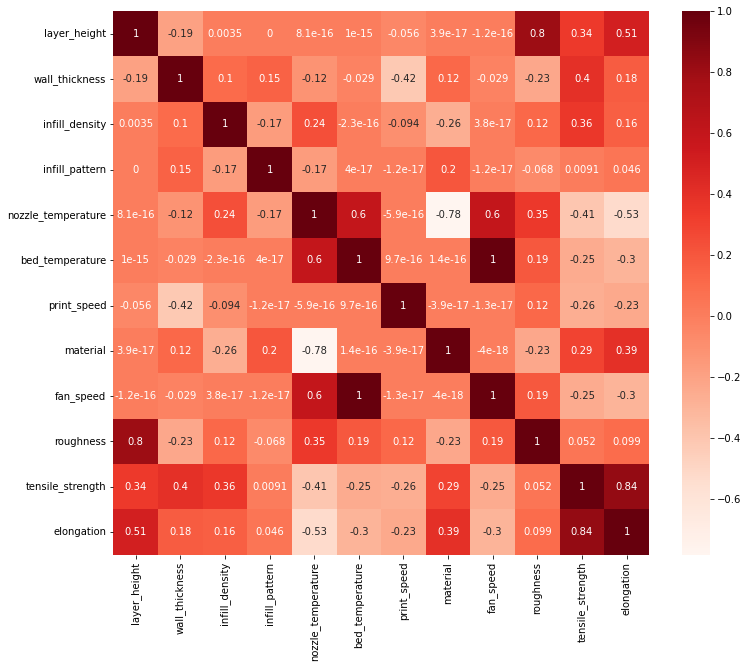

In [36]:
import seaborn as sns
plt.figure(figsize=(12,10))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap=plt.cm.Reds) #Using Pearson Correlation
plt.show()

In [37]:
target_cols = ['tensile_strength', 'roughness', 'elongation']
Y = df[target_cols].values
X = df.drop(target_cols,axis=1).values

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.09)
print(X_train.shape)
print(Y_test.shape)

(45, 9)
(5, 3)


In [39]:
# Construct a NN model using functional API
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Activation, Flatten

inputvec = Input( shape=(9,) )
x = Dense( 16, activation='relu' )(inputvec)
x = Dense( 32, activation='relu' )(x)
x = Dense( 64, activation='relu' )(x)
#x = Dropout(0.5)(x)
x = Dense( 32, activation='relu' )(x)
x = Dense( 16, activation='relu' )(x)
x = Dense( 8, activation='relu' )(x)
#x = Dropout(0.25)(x)
preds = Dense(3, activation='linear' )(x)

model = Model(name= 'NN_model_2', inputs = inputvec,outputs=preds)
model.summary()

Model: "NN_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_35 (Dense)            (None, 16)                160       
                                                                 
 dense_36 (Dense)            (None, 32)                544       
                                                                 
 dense_37 (Dense)            (None, 64)                2112      
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                                 
 dense_39 (Dense)            (None, 16)                528       
                                                                 
 dense_40 (Dense)            (None, 8)                 1

In [40]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

Epoch 1/1000
9/9 [==============================] - 0s 1ms/step - loss: 22612.7754 - accuracy: 0.4222
Epoch 2/1000
9/9 [==============================] - 0s 2ms/step - loss: 20396.8457 - accuracy: 0.4222
Epoch 3/1000
9/9 [==============================] - 0s 2ms/step - loss: 17752.2910 - accuracy: 0.4222
Epoch 4/1000
9/9 [==============================] - 0s 2ms/step - loss: 13997.8125 - accuracy: 0.4222
Epoch 5/1000
9/9 [==============================] - 0s 2ms/step - loss: 9613.2227 - accuracy: 0.4222
Epoch 6/1000
9/9 [==============================] - 0s 2ms/step - loss: 7551.1021 - accuracy: 0.4222
Epoch 7/1000
9/9 [==============================] - 0s 2ms/step - loss: 7162.7979 - accuracy: 0.4222
Epoch 8/1000
9/9 [==============================] - 0s 2ms/step - loss: 6509.7451 - accuracy: 0.4222
Epoch 9/1000
9/9 [==============================] - 0s 3ms/step - loss: 6162.4624 - accuracy: 0.4222
Epoch 10/1000
9/9 [==============================] - 0s 2ms/step - loss: 5786.1533 - ac

9/9 [==============================] - 0s 1ms/step - loss: 1738.3486 - accuracy: 0.6444
Epoch 161/1000
9/9 [==============================] - 0s 1ms/step - loss: 1771.8840 - accuracy: 0.6444
Epoch 162/1000
9/9 [==============================] - 0s 1ms/step - loss: 1861.6267 - accuracy: 0.6000
Epoch 163/1000
9/9 [==============================] - 0s 1ms/step - loss: 1749.6698 - accuracy: 0.6000
Epoch 164/1000
9/9 [==============================] - 0s 1ms/step - loss: 1605.4995 - accuracy: 0.6444
Epoch 165/1000
9/9 [==============================] - 0s 1ms/step - loss: 1702.2421 - accuracy: 0.6222
Epoch 166/1000
9/9 [==============================] - 0s 1ms/step - loss: 1884.6212 - accuracy: 0.6000
Epoch 167/1000
9/9 [==============================] - 0s 1ms/step - loss: 1821.5811 - accuracy: 0.6222
Epoch 168/1000
9/9 [==============================] - 0s 1ms/step - loss: 1595.5702 - accuracy: 0.6444
Epoch 169/1000
9/9 [==============================] - 0s 1ms/step - loss: 1862.8425 - ac

9/9 [==============================] - 0s 1ms/step - loss: 428.4576 - accuracy: 0.9333
Epoch 320/1000
9/9 [==============================] - 0s 1ms/step - loss: 360.0879 - accuracy: 0.9333
Epoch 321/1000
9/9 [==============================] - 0s 1ms/step - loss: 347.3953 - accuracy: 0.9556
Epoch 322/1000
9/9 [==============================] - 0s 1ms/step - loss: 325.2958 - accuracy: 0.8667
Epoch 323/1000
9/9 [==============================] - 0s 1ms/step - loss: 385.6574 - accuracy: 0.8889
Epoch 324/1000
9/9 [==============================] - 0s 1ms/step - loss: 334.2401 - accuracy: 0.9111
Epoch 325/1000
9/9 [==============================] - 0s 1ms/step - loss: 330.0066 - accuracy: 0.9111
Epoch 326/1000
9/9 [==============================] - 0s 1ms/step - loss: 345.4064 - accuracy: 0.8444
Epoch 327/1000
9/9 [==============================] - 0s 1ms/step - loss: 336.2179 - accuracy: 0.9333
Epoch 328/1000
9/9 [==============================] - 0s 1ms/step - loss: 343.0770 - accuracy: 0.

9/9 [==============================] - 0s 1ms/step - loss: 152.7995 - accuracy: 1.0000
Epoch 480/1000
9/9 [==============================] - 0s 1ms/step - loss: 144.2155 - accuracy: 0.9778
Epoch 481/1000
9/9 [==============================] - 0s 1ms/step - loss: 149.1974 - accuracy: 0.9778
Epoch 482/1000
9/9 [==============================] - 0s 1ms/step - loss: 155.7539 - accuracy: 1.0000
Epoch 483/1000
9/9 [==============================] - 0s 1ms/step - loss: 127.0648 - accuracy: 1.0000
Epoch 484/1000
9/9 [==============================] - 0s 1ms/step - loss: 143.4214 - accuracy: 1.0000
Epoch 485/1000
9/9 [==============================] - 0s 1ms/step - loss: 153.2648 - accuracy: 0.9556
Epoch 486/1000
9/9 [==============================] - 0s 1ms/step - loss: 140.3139 - accuracy: 1.0000
Epoch 487/1000
9/9 [==============================] - 0s 1ms/step - loss: 113.8738 - accuracy: 1.0000
Epoch 488/1000
9/9 [==============================] - 0s 1ms/step - loss: 129.2239 - accuracy: 0.

9/9 [==============================] - 0s 1ms/step - loss: 98.3374 - accuracy: 0.9778
Epoch 640/1000
9/9 [==============================] - 0s 1ms/step - loss: 81.8831 - accuracy: 1.0000
Epoch 641/1000
9/9 [==============================] - 0s 1ms/step - loss: 88.3789 - accuracy: 1.0000
Epoch 642/1000
9/9 [==============================] - 0s 997us/step - loss: 127.9169 - accuracy: 0.9778
Epoch 643/1000
9/9 [==============================] - 0s 1ms/step - loss: 104.8157 - accuracy: 0.9778
Epoch 644/1000
9/9 [==============================] - 0s 1ms/step - loss: 162.2308 - accuracy: 1.0000
Epoch 645/1000
9/9 [==============================] - 0s 1ms/step - loss: 121.6274 - accuracy: 0.9778
Epoch 646/1000
9/9 [==============================] - 0s 1ms/step - loss: 103.9808 - accuracy: 1.0000
Epoch 647/1000
9/9 [==============================] - 0s 1ms/step - loss: 100.9053 - accuracy: 0.9778
Epoch 648/1000
9/9 [==============================] - 0s 1ms/step - loss: 159.5107 - accuracy: 0.9

9/9 [==============================] - 0s 1ms/step - loss: 55.2634 - accuracy: 1.0000
Epoch 801/1000
9/9 [==============================] - 0s 1ms/step - loss: 57.9691 - accuracy: 0.9778
Epoch 802/1000
9/9 [==============================] - 0s 2ms/step - loss: 60.8792 - accuracy: 1.0000
Epoch 803/1000
9/9 [==============================] - 0s 2ms/step - loss: 60.0298 - accuracy: 1.0000
Epoch 804/1000
9/9 [==============================] - 0s 2ms/step - loss: 82.7117 - accuracy: 0.9778
Epoch 805/1000
9/9 [==============================] - 0s 1ms/step - loss: 68.9094 - accuracy: 0.9778
Epoch 806/1000
9/9 [==============================] - 0s 1ms/step - loss: 66.5615 - accuracy: 0.9778
Epoch 807/1000
9/9 [==============================] - 0s 1ms/step - loss: 56.9649 - accuracy: 0.9778
Epoch 808/1000
9/9 [==============================] - 0s 1ms/step - loss: 59.5069 - accuracy: 1.0000
Epoch 809/1000
9/9 [==============================] - 0s 1ms/step - loss: 53.5441 - accuracy: 0.9778
Epoch

9/9 [==============================] - 0s 2ms/step - loss: 65.4050 - accuracy: 0.9778
Epoch 882/1000
9/9 [==============================] - 0s 1ms/step - loss: 61.3264 - accuracy: 1.0000
Epoch 883/1000
9/9 [==============================] - 0s 1ms/step - loss: 46.4387 - accuracy: 0.9778
Epoch 884/1000
9/9 [==============================] - 0s 1ms/step - loss: 45.7961 - accuracy: 0.9778
Epoch 885/1000
9/9 [==============================] - 0s 1ms/step - loss: 47.4297 - accuracy: 1.0000
Epoch 886/1000
9/9 [==============================] - 0s 1ms/step - loss: 53.4223 - accuracy: 1.0000
Epoch 887/1000
9/9 [==============================] - 0s 1ms/step - loss: 54.4838 - accuracy: 1.0000
Epoch 888/1000
9/9 [==============================] - 0s 1ms/step - loss: 58.4195 - accuracy: 0.9778
Epoch 889/1000
9/9 [==============================] - 0s 1ms/step - loss: 65.3386 - accuracy: 1.0000
Epoch 890/1000
9/9 [==============================] - 0s 1ms/step - loss: 51.4040 - accuracy: 1.0000
Epoch

9/9 [==============================] - 0s 1ms/step - loss: 36.3795 - accuracy: 0.9778
Epoch 963/1000
9/9 [==============================] - 0s 1ms/step - loss: 36.1162 - accuracy: 1.0000
Epoch 964/1000
9/9 [==============================] - 0s 2ms/step - loss: 45.4478 - accuracy: 0.9778
Epoch 965/1000
9/9 [==============================] - 0s 1ms/step - loss: 40.2378 - accuracy: 0.9778
Epoch 966/1000
9/9 [==============================] - 0s 1ms/step - loss: 43.4524 - accuracy: 1.0000
Epoch 967/1000
9/9 [==============================] - 0s 1ms/step - loss: 39.8382 - accuracy: 0.9778
Epoch 968/1000
9/9 [==============================] - 0s 1ms/step - loss: 37.2769 - accuracy: 1.0000
Epoch 969/1000
9/9 [==============================] - 0s 1ms/step - loss: 37.0314 - accuracy: 1.0000
Epoch 970/1000
9/9 [==============================] - 0s 1ms/step - loss: 40.9093 - accuracy: 0.9778
Epoch 971/1000
9/9 [==============================] - 0s 1ms/step - loss: 37.8563 - accuracy: 1.0000
Epoch

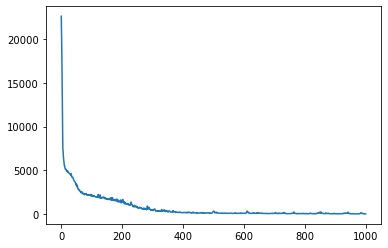

In [41]:
# Fit model to the data (train the model)
from keras.callbacks import History
history = History()

model.fit(X_train, Y_train, batch_size=5, epochs=1000, verbose=1, callbacks=[history])
# Batch size = 50 (all samples), epoch number = 10000 (the learning algorithm works through the entire dataset for 10000 times)
print('Done!')

# Plot the loss history
plt.plot(history.history['loss'])

Text(0, 0.5, 'mean squared error')

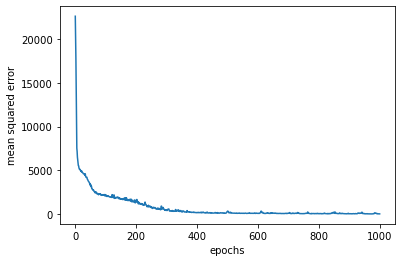

In [42]:
plt.plot(history.history['loss'],)
plt.xlabel("epochs")
plt.ylabel("mean squared error")

1/1 [==============================] - 0s 94ms/step - loss: 1755.7520 - accuracy: 1.0000
[1755.751953125, 1.0]


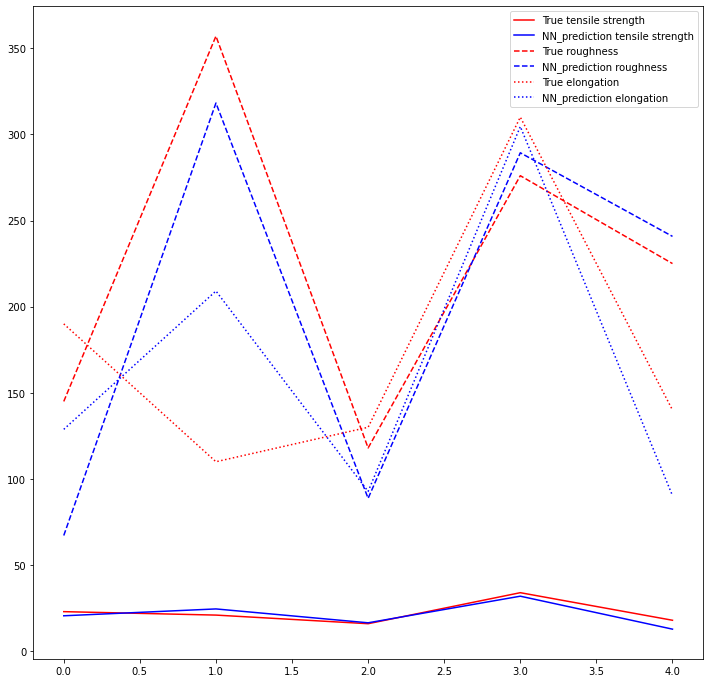

In [43]:
# Evaluate the accuracy of the model (loss: mean squared error, as defined in the step of compiling)
score = model.evaluate(X_test, Y_test, verbose=1)
print(score)

# Batch prediction & plot
Y_pred = model.predict(X_test)


plt.show()
plt.figure(figsize=(12, 12))
line1, = plt.plot(Y_test[:,0],'r-')
line2, = plt.plot(Y_pred[:,0],'b-')
line3, = plt.plot(Y_test[:,1],'r--')
line4, = plt.plot(Y_pred[:,1],'b--')
line5, = plt.plot(Y_test[:,2],'r:')
line6, = plt.plot(Y_pred[:,2],'b:')
plt.legend([line1, line2, line3, line4, line5, line6], ['True tensile strength', 'NN_prediction tensile strength', 'True roughness', 'NN_prediction roughness', 'True elongation', 'NN_prediction elongation'])